#   Differential Gene Expression Analysis

![](./images/Module2/DE_pipeline.jpg)

The next step in the pathway analysis workflow is differential expression (DE)  analysis. The goal of DE testing is to determine which genes are expressed at different levels between two or more biological conditions. These genes can offer biological insight into the processes affected by the condition(s) of interest. DE analysis means taking the normalized read count data and performing statistical analysis to discover quantitative changes in expression levels between experimental groups. For example, we use statistical testing to decide whether, for a given gene, an observed difference in read counts is significant: that is, whether it is greater than what would be expected just due to natural random variation. This learning submodule demonstrates a computational workflow for the detection of DE genes from RNA-Seq data.

## Learning Objectives:
1. Assign samples into groups and set up design matrix.
2. Perform differential expression (DE) analysis using `limma`, `t-test`, `edgeR` and `DEseq` R packages.
3. Filter and export the results table.
4. Visualization of differential expression results.

In [1]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-1.html" width=100% height=250></iframe>')

## Loading the Dataset
In this section we will perform differential expression (DE) analysis to analyze the `GSE48350` dataset that we have used in the previous submodule.
Recall from the [**GEO Data processing** ](./Module01-GEO_Data_Processing.ipynb) section, `GSE48350` contains
sequenced data of Human Alzheimer's Disease using microarray sequencing technology collected from 4 brain regions.
We have already created two groups: *disease* and *control* from the Entorhinal Cortex region. First, we need to load the data that has been saved from submodule 1.

In [1]:
# Loading data from the rds file
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
groups <- data$groups

Now we have all the data needed to perform DE analysis. We will be using 4 different methods to test differential expression: `limma`, t-tests, `edgeR`, and `DESeq2`.

## DE Analysis and Visualization Using limma.
By far, the most popular package for performing differential expression is `limma`. The package provides a flexible framework for the analysis of gene expression data, with a focus on detecting differentially expressed genes between two or more conditions.


The package offers a variety of statistical methods and models to handle different experimental designs, including single and multiple groups, paired samples, and time-series data. It also includes various normalization and quality control procedures to preprocess raw data and improve the accuracy and reproducibility of downstream analysis.


The empirical Bayesian (EB) statistical methods in the `limma` R package refer to a set of techniques used to improve the estimation of gene-specific variances and fold changes in the analysis of gene expression data.


The traditional approach to the analysis of gene expression data is to treat the variances of each gene as independent and estimate them based on the limited number of samples available. However, this can lead to inaccurate estimates due to the small sample size and high variability of gene expression data.


The EB methods in `limma` package instead borrow information from other genes in the same dataset to provide a more accurate estimate of the gene-specific variances. This is accomplished by first estimating the overall distribution of variances across all genes and then using this distribution to estimate the variances of individual genes.


One of the key advantages of the EB methods in `limma` is that they can improve the detection of differentially expressed genes, particularly for genes with low expression levels or small sample sizes. The EB methods also provide more stable estimates of variances across multiple experiments, making it easier to compare results across different datasets.

In [5]:
suppressMessages({if (!require("BiocManager", quietly = TRUE))
    suppressWarnings(install.packages("BiocManager"))
  suppressWarnings(BiocManager::install("limma", update = T))
})

In [6]:
suppressPackageStartupMessages({
  library("limma")
})

The first step of DE analysis using `limma` is to separate the samples in our dataset into the sample groups of interest. A useful function is `model.matrix`, which will create a design matrix of *0* and *1s*; one row for each sample and one column for each sample group. A *1* in a particular row and column indicates that a given sample (the row) belongs to a given group (column).

In [7]:
groups <- factor(groups$groups)
# Create design matrix with no intercept
design <- model.matrix(~0 + groups)
colnames(design) <- levels(groups)
head(design)

,c,d
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0


The `lmFit` function is used to fit the model to the data. The result of which is to estimate the expression level of each gene in each of the groups that we specified.

In [8]:
fit <- lmFit(object = norm_expression_data, design = design)  # fit linear model

In order to perform the *differential analysis*, we have to define the contrast that we are interested in. In our case we only have two groups and one contrast of interest. Multiple contrasts can be defined in the `makeContrasts` function.

In [9]:
# set up contrasts of interest and recalculate model coefficients
cts <- paste("c", "d", sep="-")
cont.matrix <- makeContrasts(contrasts = cts, levels = design)
cont.matrix

,c-d
c,1
d,-1


Fit the contrast matrix:

In [18]:
fit2 <- contrasts.fit(fit, cont.matrix)

Finally, apply the *empirical Bayes’* step to get our differential expression statistics and p-values. This step uses Bayesian statistics to infer the probability distribution using the observed expression levels. It can then calculate the log-fold changes in expression between experimental groups and the p-value:

In [21]:
# compute statistics and table of top significant genes
fit2 <- eBayes(fit = fit2, proportion = 0.01)

To see the number of significantly up- and down-regulated genes, we can use the code below to generate the summary table.

In [22]:
dt <- decideTests(object = fit2, p.value = 0.05)
summary(dt)

         c-d
Down     277
NotSig 54015
Up       383

Here, significance is defined using an adjusted p-value cutoff that is set at 5% by default. For the comparison between expression levels in *“disease”* (d) and *“control”* (c), 293 genes are found to be down-regulated and 489 genes are up-regulated. We also can extract a table of the top-ranked genes from a linear model fit using `topTable` function. By default, `topTable` arranges genes from smallest to largest adjusted p-value with associated gene information, log-FC, average log-CPM, moderated t-statistic, raw and adjusted p-value for each gene. The number of top genes displayed can be specified, where `number=Inf` includes all genes.

In [24]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-2.html" width=100% height=250></iframe>')

In [39]:
top_genes <- topTable(fit = fit2, adjust = "fdr", sort.by = "B", number = Inf)

In [40]:
head(top_genes)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
222178_s_at,-0.4473780,0.3653633,-73.01106,4.019112e-55,2.197450e-50,81.05538
224687_at,-4.1431631,2.2572347,-48.92036,5.489424e-46,1.500671e-41,74.18354
207488_at,-0.4017530,0.6243144,-39.29933,4.735684e-41,8.630785e-37,68.83493
239226_at,0.4483302,1.3245501,28.36499,7.626558e-34,1.042455e-29,58.84908
234109_x_at,-0.2289726,0.7508256,-27.67010,2.635337e-33,2.881741e-29,58.00438
212833_at,-2.5976592,1.7308944,-24.01172,2.914912e-30,2.656213e-26,52.99567


In order to perform pathway and enrichment analyses, we only focus on the genes that are statistically significant and the probe IDs that have gene symbols. We can select those genes using the following command:

In [41]:
DE_Gene <- top_genes[which(top_genes$adj.P.Val<0.05), ]
head(DE_Gene)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
222178_s_at,-0.4473780,0.3653633,-73.01106,4.019112e-55,2.197450e-50,81.05538
224687_at,-4.1431631,2.2572347,-48.92036,5.489424e-46,1.500671e-41,74.18354
207488_at,-0.4017530,0.6243144,-39.29933,4.735684e-41,8.630785e-37,68.83493
239226_at,0.4483302,1.3245501,28.36499,7.626558e-34,1.042455e-29,58.84908
234109_x_at,-0.2289726,0.7508256,-27.67010,2.635337e-33,2.881741e-29,58.00438
212833_at,-2.5976592,1.7308944,-24.01172,2.914912e-30,2.656213e-26,52.99567


Now, we can use the following script to save the DE analysis result to use in the later submodules.


In [42]:
# Save the data to the local disk using rds format
# Add one column to store the probe IDs
top_genes <- tibble::rownames_to_column(top_genes, "PROBEID")
saveRDS(top_genes, file="./data/DE_genes.rds")

In [ ]:
# save files in Google Cloud Bucket
# replace the <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
system("gsutil cp ./data/DE_genes.rds gs://<BUCKET_NAME>", intern = TRUE)

## DE Analysis Using t-test
A `t-test` is a common statistical method used to identify differentially expressed (DE) genes in gene expression data. In the context of gene expression analysis, a t-test compares the mean expression level of a gene between two groups, typically a treatment group and a control group.


The basic idea behind a t-test is to compare the difference in means between the two groups to the variability within each group. A larger difference in means relative to the variability within each group indicates a higher likelihood that the difference is statistically significant.


In the context of gene expression data, a t-test is typically applied to each gene separately. For each gene, the mean expression level in the treatment group is compared to the mean expression level in the control group. The t-test produces a p-value that indicates the probability of observing the observed difference in means by chance.


In order to identify DE genes, a significance threshold (or "alpha value") is chosen. Any gene with a p-value below this threshold is considered to be differentially expressed. The threshold is typically set at 0.05, meaning that there is a 5% chance of falsely identifying a gene as DE. We can use `row_t_equalvar` available in the `matrixTests` package to perform t-test between the two groups for each gene. Below is the code to install the necessary packages:

In [32]:
suppressMessages({
  suppressWarnings(install.packages("matrixTests", quiet = T))
})

package 'matrixTests' successfully unpacked and MD5 sums checked


In [33]:
# Load matrixTests package
suppressPackageStartupMessages({library("matrixTests")})

First we need to create two different expression matrices belong to two groups.

In [34]:
# Assign expression matrix to the count
count <- expression_data
# Divide the count matrix into two separate matrices X and Y. X is the control group and Y is the disease group
X <- count[, groups=="c"]
Y <- count[, groups=="d"]

In [35]:
# Perform t-test
res <- row_t_equalvar(x = X, y = Y, alternative = "two.sided", conf.level = 0.95)

The output is a table where rows are genes and columns are statistical information of the test. In DE analysis, we only care for the genes that are significantly different. Therefore, we will rank them based on *p-value* and remove insignificant one.

In [36]:
# Order the results based on the p-value
res <- res[order(res$pvalue), ]
# Remove insignificant genes
res <- res[res$pvalue<0.05, ]
# Show the result of top genes
head(res)

,obs.x,obs.y,obs.tot,mean.x,mean.y,mean.diff,var.x,var.y,var.pooled,stderr,df,statistic,pvalue,conf.low,conf.high,mean.null,alternative,conf.level
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
222178_s_at,39,15,54,0.1819268,0.6117714,-0.4298446,9.737616e-05,0.0006820712,0.0002547941,0.004849686,52,-88.63350,2.040469e-58,-0.4395762,-0.4201130,0,two.sided,0.95
207488_at,39,15,54,0.4270298,0.8854517,-0.4584219,9.008167e-04,0.0023830695,0.0012998848,0.010953966,52,-41.84985,1.012965e-41,-0.4804026,-0.4364411,0,two.sided,0.95
234109_x_at,39,15,54,0.6103878,0.8874354,-0.2770476,6.857523e-04,0.0012171635,0.0008288245,0.008746821,52,-31.67409,1.151538e-35,-0.2945994,-0.2594958,0,two.sided,0.95
239226_at,39,15,54,1.7324948,1.0013784,0.7311164,1.243088e-02,0.0014187732,0.0094660800,0.029559973,52,24.73332,2.009417e-30,0.6718000,0.7904328,0,two.sided,0.95
216530_at,39,15,54,0.8361470,0.5620650,0.2740821,1.299243e-03,0.0021199336,0.0015201978,0.011845926,52,23.13724,4.856399e-29,0.2503115,0.2978526,0,two.sided,0.95
216490_x_at,39,15,54,1.0243812,0.4847202,0.5396610,8.683469e-03,0.0025726176,0.0070382400,0.025488894,52,21.17240,3.173331e-27,0.4885138,0.5908082,0,two.sided,0.95


To see how many genes are left, we can use the following command

In [37]:
dim(res)

[1] 9286   18

Now, we can save the DE analysis result to use in the later submodule

In [43]:
# Saving the result to local folder
write.csv(res, file="./data/t-Test_Results.csv")
saveRDS(res, file="./data/t-Test_Results.rds")

In [ ]:
# Saving the result to Google Cloud Bucket
# replace <BUCKET_NAME> with name of your bucket that was perviously made in submodule 1
system("gsutil cp ./data/t-Test_Results.csv gs://<BUCKET_NAME>", intern = TRUE)

system("gsutil cp ./data/t-Test_Results.rds gs://<BUCKET_NAME>", intern = TRUE)

## DE Analysis Using edgeR

edgeR is a popular R package for differential expression (DE) analysis of RNA sequencing (RNA-seq) data. The package uses empirical Bayesian methods to account for biological variability and gene-specific sequencing depth, making it a robust and powerful tool for identifying DE genes.


The basic workflow for DE analysis using edgeR involves several steps:


1. Data pre-processing: Raw sequencing reads are first pre-processed to filter out low-quality reads and align them to a reference genome. This step typically includes quality control, read trimming and alignment.


2. Count matrix generation: A count matrix is generated by counting the number of reads that map to each gene in each sample. This matrix represents the raw gene expression data and is used as input for DE analysis.


3. Normalization: edgeR applies a normalization method called trimmed mean of M-values (TMM) to adjust for differences in sequencing depth between samples. This method calculates scaling factors for each sample based on the mean and variance of the log ratios of gene expression levels between pairs of samples.


4. Dispersion estimation: edgeR uses a negative binomial model to account for biological variability in gene expression data. This model estimates the dispersion of counts within and between samples, which reflects the amount of biological variability in gene expression data.


5. Differential expression analysis: edgeR uses a statistical framework called generalized linear models (GLMs) to test for differential expression between two or more groups. This method models the relationship between gene expression and experimental factors (e.g., treatment, time, condition) to identify genes that are significantly differentially expressed.


6. Multiple testing correction: To control for the high false positive rate associated with testing many genes simultaneously, edgeR applies a multiple testing correction method called the false discovery rate (FDR). This method adjusts p-values to control the expected proportion of false positives among all significant tests.


Overall, edgeR is a powerful and widely used tool for DE analysis of RNA-seq data, offering a flexible framework for the detection of DE genes that accounts for biological variability and gene-specific sequencing depth. It also provides several visualization tools to help users explore and interpret the results.

In [44]:
# Install edgeR package from Bioconductor
suppressMessages({ if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
  suppressWarnings(BiocManager::install("edgeR", update = F))
})

package 'locfit' successfully unpacked and MD5 sums checked
package 'edgeR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ASUS\AppData\Local\Temp\Rtmpey6iXc\downloaded_packages


In [45]:
# Load edgeR package
suppressPackageStartupMessages({library("edgeR")})

In [46]:
# Assigning expression matrix to count
count <- expression_data

In [47]:
# Perform DE analysis using DGEList function
dge <- DGEList(counts = count, group = factor(groups))
# Calculating the normalize factor
dge <- calcNormFactors(object = dge)
dge <- estimateDisp(y = dge)
# Perform Fisher-exact test
et <- exactTest(object = dge)
# Getting top DE genes
top_degs = topTags(object = et, n = "Inf")

Using classic mode.



In [48]:
head(top_degs$table)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
224687_at,4.904976,8.019088,4.463490e-158,2.440413e-153
212833_at,3.363579,6.860991,1.652705e-51,4.518082e-47
1558620_at,2.841310,6.619830,2.269510e-37,4.136182e-33
211318_s_at,-2.788104,7.033454,6.724743e-22,9.191883e-18
206552_s_at,3.236385,7.042412,1.493408e-15,1.633042e-11
1553191_at,1.158600,6.798425,1.489697e-06,1.357487e-02


In [49]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-3.html" width=100% height=250></iframe>')

Now, we can save the DE analysis result to use in the later submodule

In [50]:
# Saving the result to local folder
write.csv(et$table, file="./data/edgeR_Results.csv")
saveRDS(et$table, file="./data/edgeR_Results.rds")

In [ ]:
# Saving the result to Google Cloud Bucket
#replace <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
system("gsutil cp ./data/edgeR_Results.csv gs://<BUCKET_NAME>", intern = TRUE)

system("gsutil cp ./data/edgeR_Results.rds gs://<BUCKET_NAME>", intern = TRUE)

## DE Analysis Using DESeq2
DESeq2 is a popular R package for differential expression (DE) analysis of RNA sequencing (RNA-seq) data. The package uses a negative binomial distribution to model the gene expression counts and applies shrinkage estimation to improve the accuracy of differential expression analysis.


The basic workflow for DE analysis using DESeq2 involves several steps:


1. Data pre-processing: Raw sequencing reads are first pre-processed to filter out low-quality reads and align them to a reference genome. This step typically includes quality control, read trimming, and alignment.


2. Count matrix generation: A count matrix is generated by counting the number of reads that map to each gene in each sample. This matrix represents the raw gene expression data and is used as input for DE analysis.


3. Normalization: DESeq2 applies a normalization method called size factors to adjust for differences in sequencing depth between samples. This method calculates scaling factors for each sample based on the total number of reads in each sample.


4. Dispersion estimation: DESeq2 estimates the dispersion of counts within and between samples using a negative binomial distribution. This model accounts for biological variability in gene expression data and can handle low counts and overdispersion.


5. Differential expression analysis: DESeq2 uses a statistical framework called the Wald test to test for differential expression between two or more groups. This method models the relationship between gene expression and experimental factors (e.g., treatment, time, condition) to identify genes that are significantly differentially expressed.


6. Multiple testing correction: To control for the high false positive rate associated with testing many genes simultaneously, DESeq2 applies a multiple testing correction method called the Benjamini-Hochberg (BH) procedure. This method adjusts p-values to control the expected proportion of false positives among all significant tests.


DESeq2 also includes several visualization tools, such as principal component analysis (PCA) and heatmaps, to help users explore and interpret the results.


Overall, DESeq2 is a powerful and widely used tool for DE analysis of RNA-seq data, offering a flexible framework for the detection of DE genes that accounts for biological variability and gene-specific sequencing depth. It is particularly useful for analyzing low-count genes and handling complex experimental designs.

In [51]:
# Installing and loading the library
suppressMessages({ if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
  suppressWarnings(BiocManager::install("DESeq2", update = F))
})

package 'formatR' successfully unpacked and MD5 sums checked
package 'abind' successfully unpacked and MD5 sums checked
package 'SparseArray' successfully unpacked and MD5 sums checked
package 'lambda.r' successfully unpacked and MD5 sums checked
package 'futile.options' successfully unpacked and MD5 sums checked
package 'S4Arrays' successfully unpacked and MD5 sums checked
package 'DelayedArray' successfully unpacked and MD5 sums checked
package 'futile.logger' successfully unpacked and MD5 sums checked
package 'snow' successfully unpacked and MD5 sums checked
package 'GenomicRanges' successfully unpacked and MD5 sums checked
package 'SummarizedExperiment' successfully unpacked and MD5 sums checked
package 'BiocParallel' successfully unpacked and MD5 sums checked
package 'MatrixGenerics' successfully unpacked and MD5 sums checked
package 'DESeq2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ASUS\AppData\Local\Temp\Rtmpey6iXc\downloaded_pa

In [52]:
suppressPackageStartupMessages({library("DESeq2")})

In [53]:
# Contructing a group table that has information of group members for all patients.
coldata <- data.frame(
  sample = colnames(expression_data),
  condition = as.factor(groups),
  row.names = "sample" )

In [54]:
# Checking the group information of a few first patients
head(coldata)

,condition
,<fct>
GSM300173,c
GSM300177,c
GSM300181,c
GSM300186,c
GSM300189,c
GSM300192,c


In [55]:
# Perform DE analysis using DESeqDataSetFromMatrix function
suppressMessages({
  dds <- DESeqDataSetFromMatrix(countData = round(count), colData = coldata,
                              design = ~ condition)
  dds <- dds[rowSums(counts(dds)) >= 10, ]
  dds$condition <- relevel(x = dds$condition, ref = "c")
  dds <- DESeq(object = dds)
  resultsNames(dds)
  res <- results(dds)
  res <- as.data.frame(res[order(res$padj), ])
})

In [56]:
head(res)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
224687_at,11.590865,5.089289,0.2647166,19.225425,2.267736e-82,1.154096e-77
212833_at,4.138384,3.430013,0.2842036,12.068860,1.542556e-33,3.925188e-29
1558620_at,3.162742,2.979229,0.2892637,10.299352,7.093785e-25,1.203390e-20
206552_s_at,4.890227,3.353613,0.4815026,6.964891,3.286586e-12,4.181523e-08
211318_s_at,4.936976,-2.681179,0.3982190,-6.732927,1.662830e-11,1.692495e-07
1553191_at,3.876015,1.176570,0.2596787,4.530866,5.874237e-06,4.982528e-02


In [57]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-4.html" width=100% height=250></iframe>')

Now, we can save the DE analysis result to use in the later submodule

In [58]:
# Saving the result to local storage
write.csv(res, file="./data/DESeq2_Results.csv")
saveRDS(res, file="./data/DESeq2_Results.rds")

In [ ]:
#replace <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
system("gsutil cp ./data/DESeq2_Results.csv gs://<BUCKET_NAME>", intern = TRUE)

system("gsutil cp ./data/DESeq2_Results.rds gs://<BUCKET_NAME>", intern = TRUE)

## Visualization of Differential Expression Results.
To visually summarize results for all genes from the `limma` analysis we can generate a mean-difference plot using the `plotMD` function in `limma` package, which displays log-fold changes from the linear model fit against the average log-CPM values, with the differentially expressed genes highlighted. The function `plotMD` uses `fit2` object generated from DE analysis using `limma` in the above section.

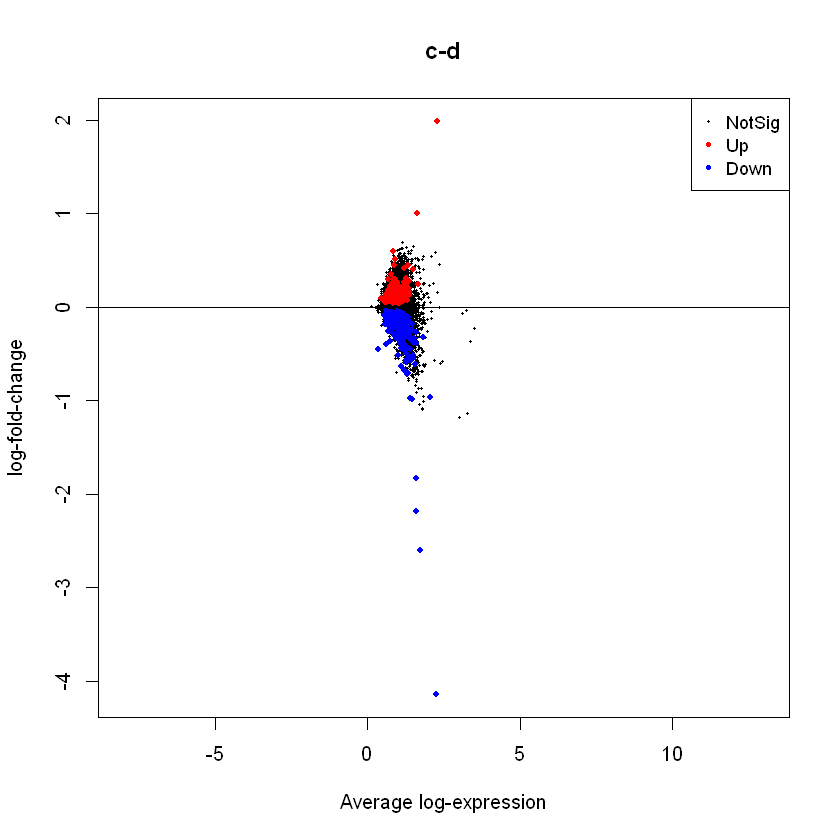

In [59]:
plotMD(fit2, column = 1, status = dt[, 1], main = colnames(fit2)[1],
       xlim=c(-8, 13), pch=20, cex=1)
abline(h=0)

We can visualize the adjusted p-value distribution for all gene using a histogram plot:

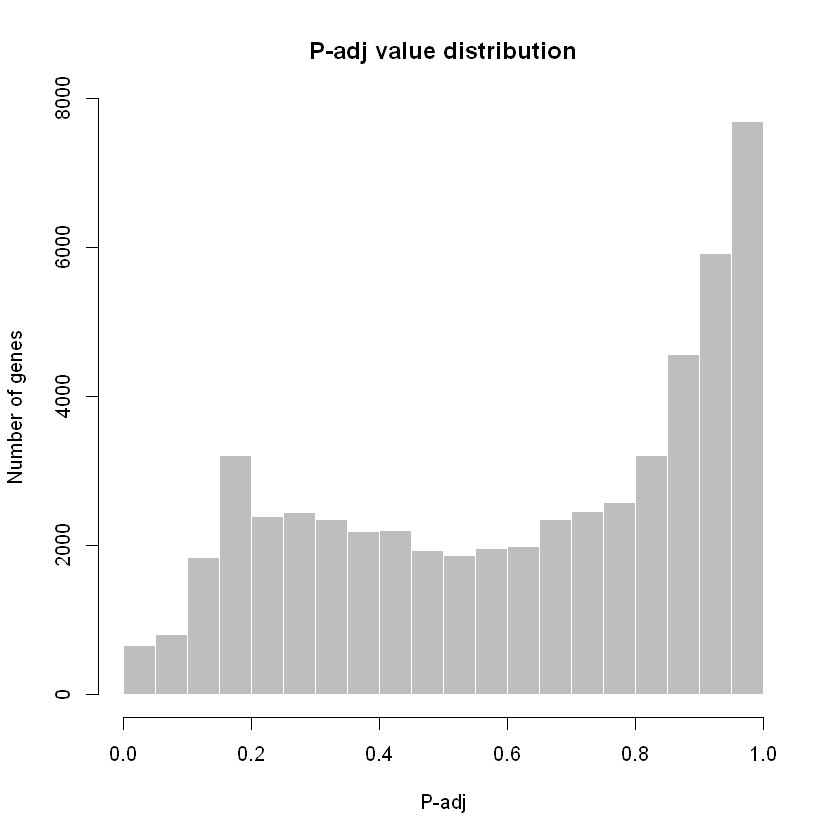

In [60]:
# Visualize and quality control test results.
# Build histogram of P-values for all genes. 
#Normal test assumption is that most genes are not differentially expressed.
tT2 <- topTable(fit2, adjust = "fdr", sort.by = "B", number = Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
     ylab = "Number of genes", main = "P-adj value distribution")

Many statistical tests work on the assumption that the data follows a normal distribution. If this assumption is not met, then we must choose a different test that does not require normally distributed data. A Q-Q plot allows researchers to visually assess whether the distribution of the moderated t-statistic follows the normal distribution. In a Q-Q plot for the moderated t-statistic, the expected quantiles of a normal distribution are plotted against the observed quantiles of the moderated t-statistic. If the distribution of moderated t-statistic follows the normal distribution, then the points on the Q-Q plot will fall along a straight line. Deviations from a straight line may indicate departures from normality.

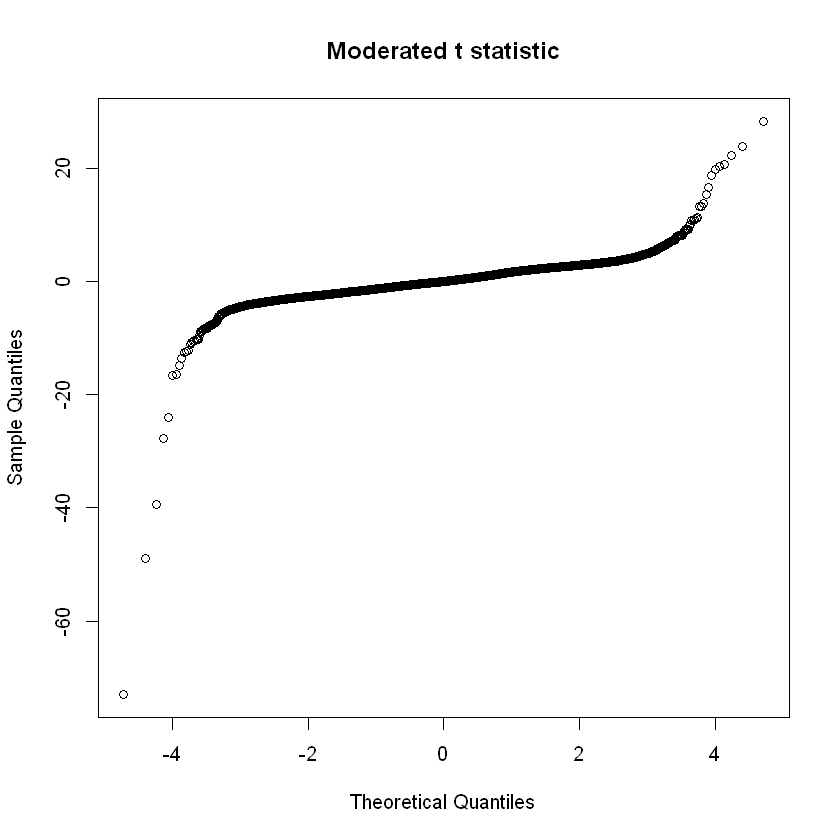

In [61]:
# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

A volcano plot is a special scatterplot that is a common way of visualising the results of a DE analysis. The *x* axis shows the *log-fold* change and the *y* axis is some measure of statistical significance, which in this case is the log-odds, or “B” statistic. A characteristic “volcano” shape should be seen.

[1] "c-d"

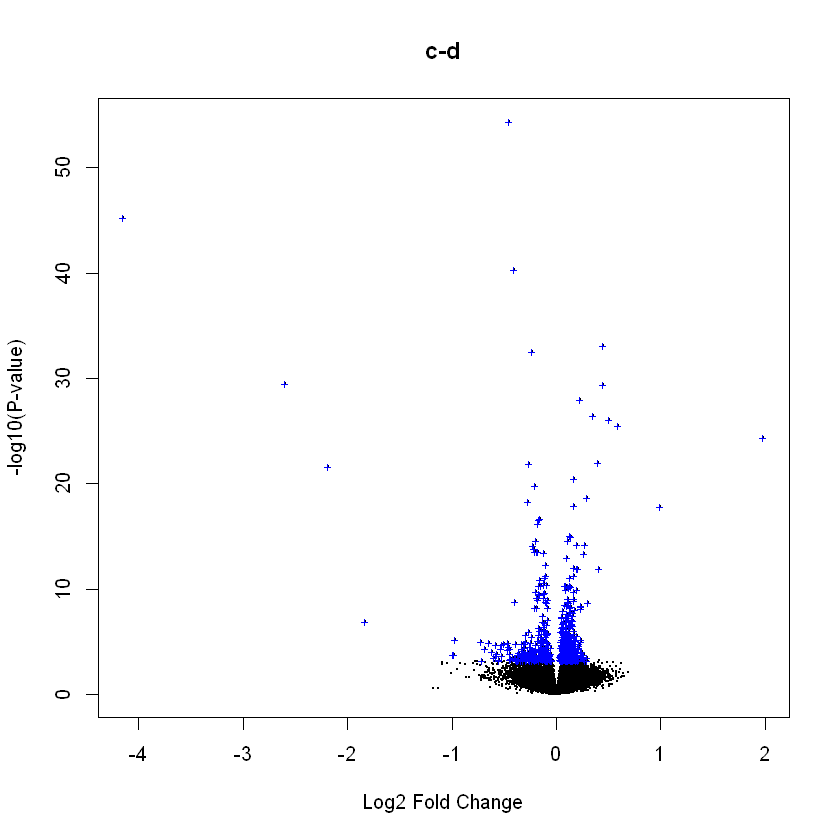

In [62]:
# volcano plot (log P-value vs log fold change)
dT <- decideTests(fit2, adjust.method = "fdr", p.value = 0.05)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
volcanoplot(fit2, coef = ct, main=colnames(fit2)[ct], pch=20,
            highlight=length(which(dT[, ct]!=0)), names=rep('+', nrow(fit2)))


In [63]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2.html" width=100% height=250></iframe>')

The next submodule will show how to identify the pathways that these genes are involved in. 


In [ ]:
sessionInfo()